### Topic Analysis using LDA Topic Model (Community Dataset #2: week 52 (2020) - week 4 (2021) - weekly dataset)

#### Import core libraries

In [1]:
# Import Core library
import sys
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, nltk, datetime as dt, seaborn as sns
import emoji
import little_mallet_wrapper
import plotly.express as px
import wordcloud
import openpyxl
from pprint import pprint
from cleantext import clean

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
[nltk_data] Downloading package stopwords to C:\Users\Ivory-
[nltk_data]     UALR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
#provide string with emojis
# text = "This sample text contains laughing emojis 😀 😃 😄 😁 😆 😅 😂 🤣"
# result = text.encode('ascii', 'ignore').decode('ascii')
# print(result)

#### Import Dataset

In [4]:
week1 = (r"2nd_analysis_LDAmodel\weekly_datasets\split_by_week1.xlsx")
week2 = (r"2nd_analysis_LDAmodel\weekly_datasets\split_by_week2.xlsx")
week3 = (r"2nd_analysis_LDAmodel\weekly_datasets\split_by_week3.xlsx")
week4 = (r"2nd_analysis_LDAmodel\weekly_datasets\split_by_week4.xlsx")
week51 = (r"2nd_analysis_LDAmodel\weekly_datasets\split_by_week51.xlsx")
week52 = (r"2nd_analysis_LDAmodel\weekly_datasets\split_by_week52.xlsx")
week53 = (r"2nd_analysis_LDAmodel\weekly_datasets\split_by_week53.xlsx")

# Import Dataset
df = pd.read_excel(week51)

In [2]:
# Import files to build models
excel_file = r"2nd_analysis_LDAmodel\topic_dist (51 -04) (no_duplicate)\topic_dist_week4.xlsx"
lda_file = r"2nd_analysis_LDAmodel\LDAviz 51-04 (no_duplicate)\week4_LDAviz_no_duplicate.html"

In [ ]:
df.tail(2)

#### Importing Dataset (Cummulative Analysis)

In [5]:
# Import multiple files and convert to dataframes (cumulative models)
import glob

path = r".\prob_dist (cummulative)\week"
excel_files = glob.glob(path + "\*.xlsx")

df_list = (pd.read_excel(file) for file in excel_files)

dataframes_list = []
for file in range(len(excel_files)):
    temp_df = pd.read_excel(excel_files[file])
    dataframes_list.append(temp_df)

<>:5: DeprecationWarning: invalid escape sequence \*
<>:5: DeprecationWarning: invalid escape sequence \*
C:\Users\IVORY-~1\AppData\Local\Temp/ipykernel_10144/672462022.py:5: DeprecationWarning: invalid escape sequence \*
  excel_files = glob.glob(path + "\*.xlsx")


In [6]:
print(len(dataframes_list))

7


In [ ]:
dataframes_list[0]

In [49]:
# Assign each cummulated excel file to a dataframe
df51, df51_01, df51_02, df51_03, df51_04, df51_52, df51_53 = dataframes_list[:]

# df51_53.week_number.unique()

#### Process Dataset

In [57]:
# Function to remove twitter specific characters
def get_url_patern():
    return re.compile(
        r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'
        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')

def get_hashtags_pattern():
    return re.compile(r'#\w*')

def get_single_letter_words_pattern():
    return re.compile(r'(?<![\w\-])\w(?![\w\-])')

def get_blank_spaces_pattern():
    return re.compile(r'\s{2,}|\t')

def get_twitter_reserved_words_pattern():
    return re.compile(r'(RT|rt|FAV|fav|VIA|via)')

def get_mentions_pattern():
    return re.compile(r'@\w*')

def process_text(word):
  word=re.sub(pattern=get_url_patern(), repl="", string=word)
  word=re.sub(pattern=get_mentions_pattern(), repl="", string=word)
  word=re.sub(pattern=get_hashtags_pattern(), repl="", string=word)
  word=re.sub(pattern=get_twitter_reserved_words_pattern(), repl='', string=word)
  word=re.sub(r'http\S+', "", word)  # remove http links
  word=re.sub(r'bit.ly/\S+', "", word)  # rempve bitly links
  word=word.strip('[link]')  # remove [links]
  word=re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', "", word)  # remove retweet
  word=re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', "", word)  # remove tweeted at
  word=word.encode('ascii', 'ignore').decode('ascii')
#   word=clean(word, no_emoji=True)
  return word


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

<>:30: DeprecationWarning: invalid escape sequence \s
<>:30: DeprecationWarning: invalid escape sequence \s
C:\Users\IVORY-~1\AppData\Local\Temp/ipykernel_9556/361431163.py:30: DeprecationWarning: invalid escape sequence \s
  word=re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', "", word)  # remove retweet


In [143]:
# Clean text and remove twitter specific characters
df.text = df.apply(lambda row: process_text(row.text), 1)

# Remove duplicates, punctuations, stop words, digits and turn text to lowercase (with duplicates)
data = [little_mallet_wrapper.process_string(text, numbers='remove') for text in df.text]

# Remove punctuations
data_words = list(sent_to_words(data))
print(data_words[:10])

In [58]:
'''Process text and remove duplicates, punctuations, stop words, digits and turn text to lowercase for cummulated files'''
data_words_list = []

for df in dataframes_list:
    df.text = df.apply(lambda row: process_text(row.text), 1)
    data = [little_mallet_wrapper.process_string(text, numbers='remove') for text in df.text]
    data_words = list(sent_to_words(data))
    data_words_list.append(data_words)

#### N-grams & Lemmatization

In [63]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [62]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 40000000

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
print(data_lemmatized[:10])

In [64]:
'''Lemmatize words for cummulated files'''
lemmatized_list = []

for data_words in data_words_list:
    
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    nlp.max_length = 40000000
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    lemmatized_list.append(data_lemmatized)

In [73]:
# Export lemmatized data for document similarity evaluation
# corpus_df = pd.DataFrame(data_lemmatized)
# corpus_df.to_csv('prob_dist (no_duplicates)/corpus_week4.csv', index=False, header=False)

In [66]:
# Assign each cummulated excel file to a dataframe
corpus51, corpus51_01, corpus51_02, corpus51_03, corpus51_04, corpus51_52, corpus51_53 = lemmatized_list[:]
corpus_list = [corpus51, corpus51_01, corpus51_02, corpus51_03, corpus51_04, corpus51_52, corpus51_53]

In [71]:
# Export lemmatized data for document similarity evaluation (cummulated files)
weeks = ["51", "51_01", "51_02", "51_03", "51_04", "51_52", "51_53"]
for corpus, week in zip(corpus_list, weeks):
    corpus_df = pd.DataFrame(corpus)
    corpus_df.to_csv('.\prob_dist (cummulative)\corpus_docs\corpus_{}.csv'.format(week), index=False, header=False)

<>:5: DeprecationWarning: invalid escape sequence \p
<>:5: DeprecationWarning: invalid escape sequence \p
C:\Users\IVORY-~1\AppData\Local\Temp/ipykernel_9556/1258600162.py:5: DeprecationWarning: invalid escape sequence \p
  corpus_df.to_csv('.\prob_dist (cummulative)\corpus_docs\corpus_{}.csv'.format(week), index=False, header=False)


In [150]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[], [(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1), (9, 1), (10, 1)], [(11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)], [(3, 1), (10, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)], [(29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(18, 1), (35, 1), (36, 1), (37, 1)], [(38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)], [(47, 1), (48, 1), (49, 1), (50, 1)]]


#### Building the LDA Model

In [154]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           iterations=50,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.48895704136867

Coherence Score:  0.53899512434042


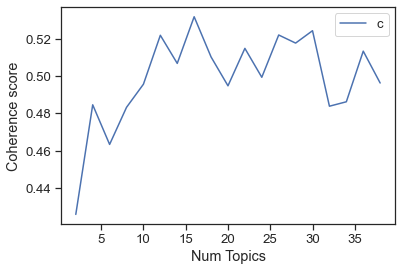

In [152]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=2)

# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [153]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
# NB: From pyLDAvis visualization, 
# week 51 optimal number of topics is 12
# week 1 optimal number of topics is 6
# week 2 optimal number of topics is 6
# week 3 optimal number of topics is 8
# week 4 optimal number of topics is 4

Num Topics = 2  has Coherence Value of 0.4258
Num Topics = 4  has Coherence Value of 0.4846
Num Topics = 6  has Coherence Value of 0.4634
Num Topics = 8  has Coherence Value of 0.4832
Num Topics = 10  has Coherence Value of 0.4956
Num Topics = 12  has Coherence Value of 0.5219
Num Topics = 14  has Coherence Value of 0.5068
Num Topics = 16  has Coherence Value of 0.5318
Num Topics = 18  has Coherence Value of 0.5103
Num Topics = 20  has Coherence Value of 0.4948
Num Topics = 22  has Coherence Value of 0.5149
Num Topics = 24  has Coherence Value of 0.4994
Num Topics = 26  has Coherence Value of 0.522
Num Topics = 28  has Coherence Value of 0.5177
Num Topics = 30  has Coherence Value of 0.5243
Num Topics = 32  has Coherence Value of 0.4839
Num Topics = 34  has Coherence Value of 0.4862
Num Topics = 36  has Coherence Value of 0.5134
Num Topics = 38  has Coherence Value of 0.4963


In [157]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.019*"election" + 0.009*"know" + 0.009*"vote" + 0.008*"people" + '
  '0.008*"get" + 0.007*"state" + 0.006*"lose" + 0.006*"go" + 0.006*"time" + '
  '0.005*"great"'),
 (1,
  '0.029*"election" + 0.021*"steal" + 0.015*"vote" + 0.009*"republican" + '
  '0.009*"lie" + 0.007*"people" + 0.007*"stop" + 0.007*"know" + 0.007*"trump" '
  '+ 0.006*"pay"'),
 (2,
  '0.010*"state" + 0.009*"election" + 0.007*"think" + 0.007*"fail" + '
  '0.007*"still" + 0.006*"make" + 0.006*"do" + 0.006*"trump" + 0.005*"never" + '
  '0.005*"help"'),
 (3,
  '0.011*"election" + 0.008*"say" + 0.007*"right" + 0.007*"need" + '
  '0.006*"time" + 0.006*"get" + 0.006*"much" + 0.005*"work" + '
  '0.005*"alex_jone" + 0.005*"try"')]


#### Visualize Topic Distribution & Keywords

In [158]:
topic_dist = pd.DataFrame()

# Code to view the Ist 4 keywords per topic
for index, topic in lda_model.show_topics(formatted=False, num_words= 10):
    words = [w[0] for w in topic]
    topic_distributions_df = ["".join(topic[:4]) for topic in words]
    topic_dist = topic_dist.append(pd.Series([index, words]), ignore_index=True)
    
    # print('Topic: {} \nWords: {}'.format(index, words))
    # print(topic_distributions_df)
    
topic_dist.columns = ['Topic_Number', 'Topic_Words']
# Export topic word distribution per topic to excel file
topic_dist.to_excel(excel_file, index=False, header=True)

C:\Users\Ivory-UALR\AppData\Local\Temp\ipykernel_12184\3450330339.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_dist = topic_dist.append(pd.Series([index, words]), ignore_index=True)
C:\Users\Ivory-UALR\AppData\Local\Temp\ipykernel_12184\3450330339.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_dist = topic_dist.append(pd.Series([index, words]), ignore_index=True)


In [159]:
topic_dist

,Topic_Number,Topic_Words
0,0,"[stop, lose, try, much, man, think, make, than..."
1,1,"[know, trump, well, real, voter, time, right, ..."
2,2,"[election, steal, vote, fraud, go, pay, never,..."
3,3,"[work, state, riot, republican, way, take, run..."


In [155]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\Ivory-UALR\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.210133  0.011376       1        1  30.802353
3     -0.058408 -0.185775       2        1  24.385176
1     -0.092179  0.087536       3        1  23.163928
0     -0.059545  0.086864       4        1  21.648542, topic_info=         Term       Freq      Total Category  logprob  loglift
21   election  66.000000  66.000000  Default  30.0000  30.0000
150     steal  29.000000  29.000000  Default  29.0000  29.0000
177      know  21.000000  21.000000  Default  28.0000  28.0000
28       work  13.000000  13.000000  Default  27.0000  27.0000
54      fraud  15.000000  15.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
117      vote   5.277393  28.455808   Topic4  -4.9631  -0.1547
159     state   4.359470  15.565281   Topic4  -5.1542   0.2575
557     money   3.542386   7.951215   Topic4  -5.3618   0.7217
124    people   3.591616  14.733105   Topic4  -5.3480   0.1187
121      help   3.466392  10.008122   Topic4  -5.3835   0.4699

[203 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
501       3  0.993169         account
276       3  0.848389             act
707       4  0.862574  administration
142       3  0.167598       alex_jone
142       4  0.670392       alex_jone
...     ...       ...             ...
28        2  0.994108            work
390       3  0.822071           wrong
390       4  0.205518           wrong
473       4  0.895731            year
325       4  0.849252             yet

[204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [160]:
# Export LDA Model
pyLDAvis.save_html(vis, lda_file)